In [2]:
from __future__ import division

from modules import * 
%matplotlib inline 

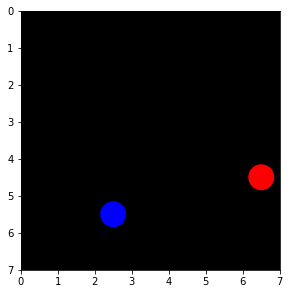

In [3]:
#make environment
maze = eu.gridworld([eu.height, eu.width],
                    rho        = eu.obs_rho,
                    num_pc     = eu.place_cells, 
                    pc_fwhm    = eu.fwhm, 
                    maze_type  = eu.mazetype, 
                    port_shift = eu.portshift)
#show environment
eu.make_env_plots(maze,1,0)

## test out gridworld wrapper. 
env = eu.gymworld(maze)

In [ ]:
# MF module parameters
dims = [env.observation_space.shape[0],100,50,env.action_space.n]
MF = mf.AC_Net(dims)
discount_factor = 0.98

#learning parameters
eta = 5e-4 #gradient descent learning rate
opt = mf.optim.Adam(MF.parameters(), lr = eta)

# EC module parameters
EC = ec.ep_mem(MF,50)

#----------------
# Run Parameters
#----------------
#trial parameters
NUM_TRIALS = 1
NUM_EVENTS = 200

In [ ]:
# prime run parameters
EC.reset_cache()
reward = env.reward
timestamp = 0

In [ ]:
# set up runtime, blocktime, print run started

#==================================
# Run Trial
#==================================
for trial in xrange(NUM_TRIALS):
    # prime trial
    state = Variable(torch.FloatTensor(env.reset()))
    reward_sum = 0
    v_last = 0
    trial_start = time.time()
    
    for event in xrange(NUM_EVENTS):
        # pass state through MF module
        policy_MF, value_ = MF(state)
        
        
        # pass state through EC module
        policy_EC = EC.recall_mem(state.data[0],reward)
        
        # get policy composed of MF and EC outputs
        policy_ = EC.composite_policy(policy_MF, policy_EC)
        
        choice, policy, value = mf.select_action_end(MF,policy_, value_)
        choice_prob = policy[choice]
        
        if event < NUM_EVENTS: 
            next_state, reward, done, info = env.step(choice)
        
        MF.rewards.append(reward)
        # update state
        state = Variable(torch.FloatTensor(next_state))
        
        #compute eligibility trace/rpe approximation
        delta = reward - value - v_last
        
        print policy_MF.shape, policy_EC.shape
        #add event to memory cache
        EC.add_mem(tuple(next_state[0]), choice, delta, timestamp)
        ### is it supposed to be current state?? 
        reward_sum += reward
        v_last = value
        
        timestamp += 1
        